In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys, time, pickle, math
import scipy

%matplotlib inline

In [49]:
def import_result_penalizedEM(fname):
    with open(fname, "rb") as p:
        res1 = pickle.load(p)
    pi = [r["pi"] for r in res1]
    mu = [r["mu"] for r in res1]
    conv = [r["conv"] for r in res1]
    p_loss = [r["p_loss"] for r in res1]
    d_loss = [r["d_loss"] for r in res1]
    iters = [r["iters"] for r in res1]
    time = [r["time"] for r in res1]
    return pi, mu, conv, p_loss, d_loss, iters, time

def import_result_GD(fname):
    res = np.load(fname)
    pi = res["pi"]
    mu = res["mu"]
    cov = res["cov"]
    p_loss = res["train_p_losses"]
    d_loss = res["train_d_losses"]
    return pi, mu, cov, p_loss, d_loss

In [141]:
def MoG_prob(x, pi, mu, cov=None):
    K, dim = mu.shape
    if cov is None:
        cov = np.tile(np.eye(dim), (K, 1, 1))
    assert x.shape == (dim,)
    assert pi.shape == (K,)
    assert cov.shape == (K, dim, dim)
    prob = 0.0
    for k in range(K):
        s, logdet = np.linalg.slogdet(cov[k] + np.eye(dim) * 1e-3)
        # print(s, np.exp(logdet))
        assert s > 0
        log_prob_k = -dim * 0.5 * math.log(2 * math.pi) - 0.5 * logdet - 0.5 * (x - mu[k]).dot(x - mu[k])
        prob += np.exp(log_prob_k) * pi[k]
    return prob

def MoG_plot(pi, mu, cov=None):
    plt.figure(figsize=(5, 5))
    
    x1 = np.linspace(-2.0, 8.0, 101)
    x2 = np.linspace(-2.0, 8.0, 101)
    p_lists = []
    for _x2 in x2:
        p = []
        for _x1 in x1:
            p.append(MoG_prob(np.array((_x1, _x2)), pi, mu, cov) )
        p_lists.append(p)
    P = np.array(p_lists)
    print(p_lists[50][50])
    print(p_lists[25][50])
    print(p_lists[50][25])
    
    plt.imshow(P, origin='lower', interpolation='bilinear')
#     plt.imshow(P, origin='lower', interpolation=None)
    plt.xticks(np.linspace(0, 100, 6), np.linspace(-2, 8, 6))
    plt.yticks(np.linspace(0, 100, 6), np.linspace(-2, 8, 6))

def calc_KL(P, Q, x1_linspace, x2_linspace=None):
    # KL(P, Q)
    if x2_linspace is None:
        x2_linspace = x1_linspace
        
    points = [np.array((x1, x2)) for x2 in x2_linspace for x1 in x1_linspace]
    P_probs = [P(x) for x in points]
    Q_probs = [Q(x) for x in points]
    KL = scipy.stats.entropy(P_probs, Q_probs)
    return KL

In [113]:
pi, mu, cov, p_loss, d_loss, iters, time = import_result_penalizedEM("results_multi_adv_EM/Penalized-K=10-lam=1.0-N=100.p")

In [114]:
mu[0]

array([[ 1.44210441,  2.85441939],
       [ 1.56349501,  3.12076463],
       [ 4.24109712,  1.98342337],
       [ 2.26669274,  0.68492765],
       [ 2.28988464,  0.70477892],
       [-0.23408065,  0.71630762],
       [ 1.10296503,  4.32656956],
       [ 2.57509285,  3.84400769],
       [ 1.77038971,  1.77984783],
       [ 1.0200885 ,  3.0389414 ]])

In [115]:
pi[0]

array([0.0900266 , 0.10559553, 0.06483004, 0.12078863, 0.17142164,
       0.02918373, 0.08311857, 0.12405128, 0.05502646, 0.15595753])

In [101]:
print(MoG_prob(np.array((1, 3)), pi[0], mu[0], cov[0]))
print(MoG_prob(np.array((3, 1)), pi[0], mu[0], cov[0]))
print(MoG_prob(np.array((1, 1)), pi[0], mu[0], cov[0]))
print(MoG_prob(np.array((3, 3)), pi[0], mu[0], cov[0]))
print(MoG_prob(np.array((5, 5)), pi[0], mu[0], cov[0]))

0.05268769762354471
0.042403414201895924
0.049771582177358074
0.04697040355298992
0.00018031568493763765


In [102]:
cov[0]

array([[[ 1.53481016, -0.72105702],
        [-0.72105702,  1.63640878]],

       [[ 2.02835292, -0.36725344],
        [-0.36725344,  0.28185497]],

       [[ 0.52432434,  0.08464046],
        [ 0.08464046,  3.53999839]]])

0.3026170481964562
0.15217323678095823
0.45752578215769024


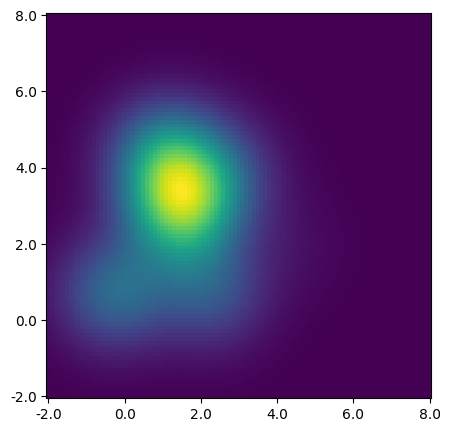

In [116]:
plt.style.use('default')
MoG_plot(pi[0], mu[0], cov[0])

In [117]:
time

[37.514862060546875, 30.84552550315857]

- Losses

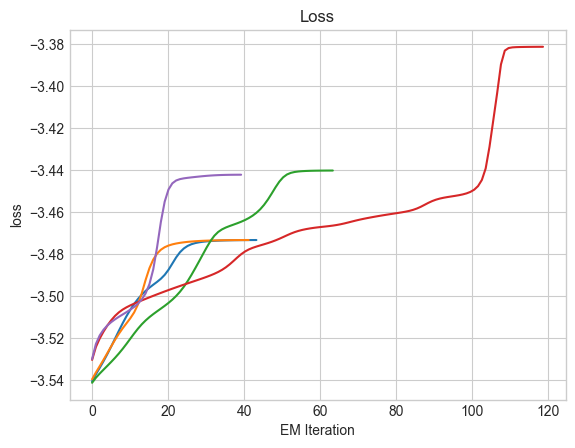

In [108]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()

plt.title("Loss")
plt.xlabel("EM Iteration")
plt.ylabel("loss");
x = np.linspace(0, 180, 180)
for loss in d_loss:
    ax.plot(x[:len(loss)-1], loss[1:])


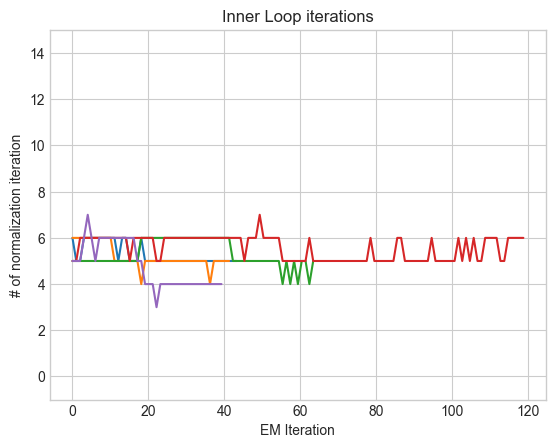

In [109]:
fig = plt.figure()
ax = plt.axes()

plt.ylim(-1, 15);
plt.title("Inner Loop iterations")
plt.xlabel("EM Iteration")
plt.ylabel("# of normalization iteration");
x = np.linspace(0, 180, 180)
for i in iters:
    ax.plot(x[:len(i)], i)


In [8]:
data_fname = 'data_multi_adv.npz'
load_data = np.load(data_fname)
true_pi = load_data['pi']
true_mu = load_data['mu']
samples = load_data['samples']
adv_sample = load_data['adv_sample']

In [9]:
true_pi

array([0.0960792 , 0.17889669, 0.25452535, 0.19189888, 0.27859988])

In [10]:
true_mu

array([[1., 1.],
       [1., 5.],
       [3., 3.],
       [5., 1.],
       [5., 5.]])

In [119]:
print(MoG_prob(np.array((1, 3)), true_pi, true_mu))
print(MoG_prob(np.array((3, 1)), true_pi, true_mu))
print(MoG_prob(np.array((1, 1)), true_pi, true_mu))
print(MoG_prob(np.array((3, 3)), true_pi, true_mu))
print(MoG_prob(np.array((5, 5)), true_pi, true_mu))

0.011397077640194667
0.01167676173401176
0.016037191368298117
0.04263940473635905
0.04505723715872976


0.04263940473635905
0.007246974936679262
0.007000082972782875


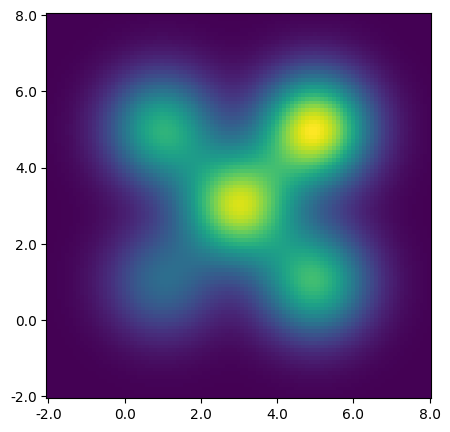

In [118]:
plt.style.use('default')
MoG_plot(true_pi, true_mu)

0.06490553330314895
0.11256231503061162
0.013969058705653124
0.06849927513972712
0.07085386166129576
0.025567829928906657
0.04417940800343305
0.07270774679821085
0.03259669480401742
0.039707449324319695
0.0834946554177684
0.023732270604221454


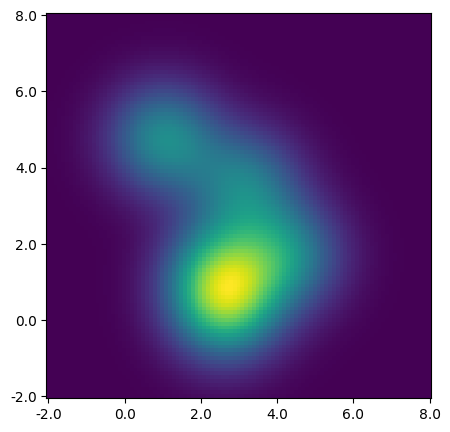

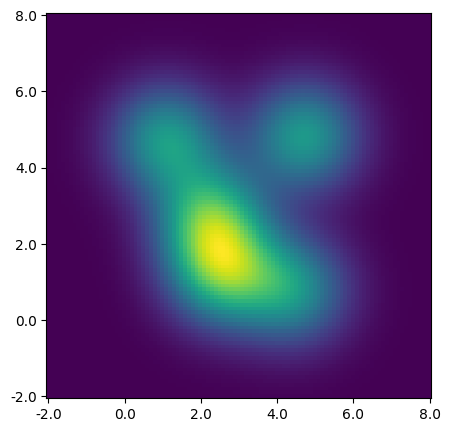

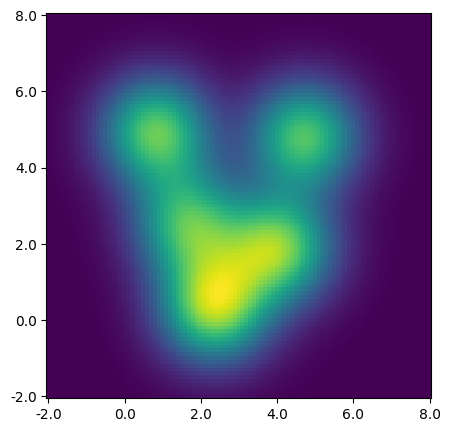

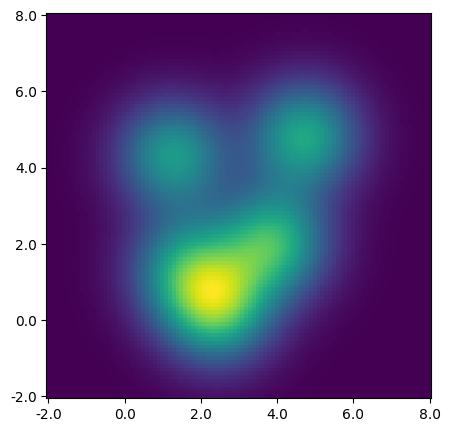

In [97]:
plt.style.use('default')
for i in range(len(pi)):
    MoG_plot(pi[i], mu[i], cov[i])

In [24]:
#K=5-lam=0.1
pi, mu, cov, p_loss, d_loss, iters, time = import_result_penalizedEM("results_multi_adv_EM/Penalized-K=5-lam=0.1-N=500.p")
plt.style.use('seaborn-whitegrid')

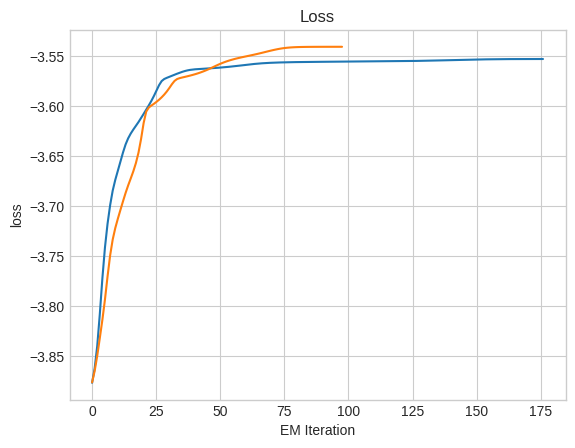

In [17]:
fig = plt.figure()
ax = plt.axes()

plt.title("Loss")
plt.xlabel("EM Iteration")
plt.ylabel("loss");
x = np.linspace(0, 200, 200)
for loss in d_loss:
    ax.plot(x[:len(loss)-1], loss[1:])

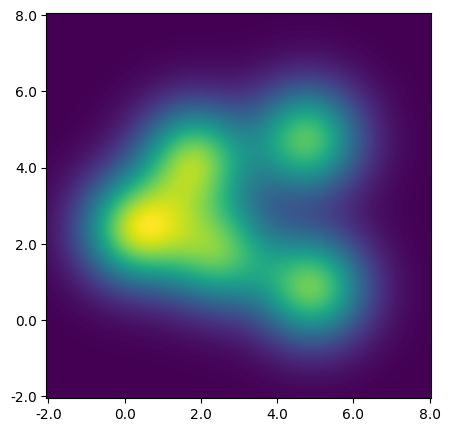

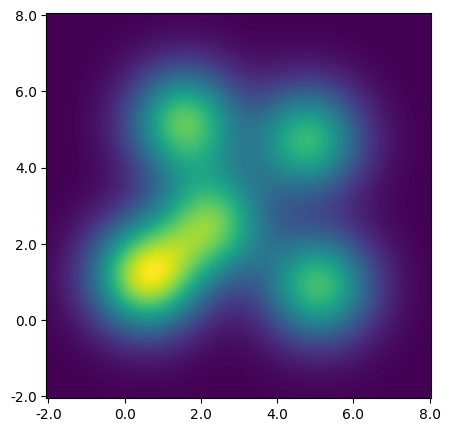

In [25]:
plt.style.use('default')
for i in range(len(pi)):
    MoG_plot(pi[i], mu[i], cov[i])

In [12]:
pi

[array([0.12073698, 0.35920676, 0.2136893 , 0.16932739, 0.13703956]),
 array([0.22916363, 0.26864422, 0.14931236, 0.17369194, 0.17918784]),
 array([0.26562402, 0.1495686 , 0.32017924, 0.13874593, 0.12588221]),
 array([0.15051125, 0.13994171, 0.23524351, 0.13690466, 0.33739887])]

## GD Results

In [120]:
pi, mu, cov, p_loss, d_loss = import_result_GD("results_multi_adv/result-adv-gd-K=5-lam=0.1-id=1.npz")
# plt.style.use('default')
# MoG_plot(pi, mu, cov)

In [121]:
pi

array([8.4965384e-01, 3.8272545e-02, 9.2062593e-02, 1.9253429e-02,
       7.5753988e-04], dtype=float32)

In [122]:
mu

array([[ 3.1303084 ,  3.022751  ],
       [ 1.2437593 ,  0.8808802 ],
       [ 1.9270577 ,  0.41488346],
       [ 0.3477477 ,  0.85310125],
       [-0.3349814 , -0.26630133]], dtype=float32)

In [123]:
cov

array([[[ 2.8046649 , -0.68443924],
        [-0.68443924,  2.616781  ]],

       [[ 0.09862806, -0.02173802],
        [-0.02173802,  0.00578957]],

       [[ 1.7095604 ,  0.1578706 ],
        [ 0.1578706 ,  0.0179659 ]],

       [[ 0.05328948,  0.09892942],
        [ 0.09892942,  0.18365782]],

       [[ 1.998317  ,  1.3004818 ],
        [ 1.3004818 ,  1.2936857 ]]], dtype=float32)

1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.897234180

1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.876159051

1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.897234180

1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.876159051

1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.876159051

1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.897234180

1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.897234180

1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.897234180

1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.0002038896080

1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.0002038896080

1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.0002379472264

1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.0002379472264

1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.0002379472264

1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.007519192083

1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.007519192083

1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.007519192083

1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.007519192083

1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.0002038896080

1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.0002038896080

1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.0002038896080

1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.0002038896080

1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.876159051

1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.876159051

1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.876159051

1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.876159051

1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.897234180

1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.897234180

1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.0002379472264

1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.897234180

1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.0002379472264

1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.0002379472264

1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.0002379472264

1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.0002379472264

1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.007519192083

1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.897234180

1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.007519192083

1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.007519192083

1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.0002038896080

1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.0002038896080

1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.0002038896080

1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.0002038896080

1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.876159051

1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.876159051

1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.876159051

1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.876159051

1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.897234180

1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.897234180

1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.897234180

1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.897234180

1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.0002379472264

1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.0002379472264

1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.0002379472264

1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.0002379472264

1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.007519192083

1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.007519192083

1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.007519192083

1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.007519192083

1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.0002038896080

1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.0002038896080

1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.0002038896080

1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.0002038896080

1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.876159051

1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.876159051

1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.876159051

1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.876159051

1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.897234180

1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.897234180

1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.897234180

1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.897234180

1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.0002379472264

1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.0002379472264

1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.0002379472264

1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.0002379472264

1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.007519192083

1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.007519192083

1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.007519192083

1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.007519192083

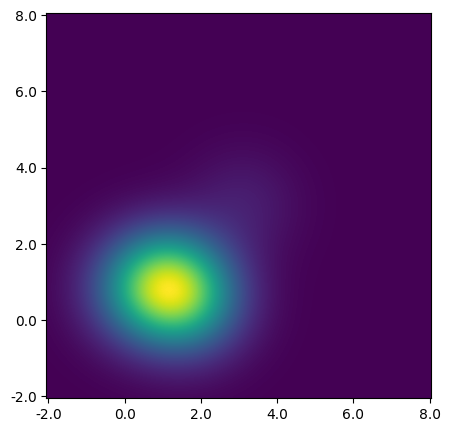

In [137]:
plt.style.use('default')
MoG_plot(pi, mu, cov)

In [138]:
print(MoG_prob(np.array((1, 1)), pi, mu, cov))
print(MoG_prob(np.array((1, 3)), pi, mu, cov))
print(MoG_prob(np.array((3, 1)), pi, mu, cov))
print(MoG_prob(np.array((3, 3)), pi, mu, cov))
print(MoG_prob(np.array((5, 5)), pi, mu, cov))

1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
0.6634005439436558
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
0.06909869055248131
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
0.183125662241824
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
0.0647338591067628
1.0 6.8761590511618556
1.0 0.00020388960800450597
1.0 0.0075191920838162665
1.0 0.00023794722649281977
1.0 0.8972341808110785
0.001271738087772962


In [159]:
pi_GD, mu_GD, cov_GD, _, _ = import_result_GD("results_multi_adv/result-adv-gd-K=10-lam=0.1-id=1.npz")
pi_EM, mu_EM, cov_EM, _, _, _, _ = import_result_penalizedEM("results_multi_adv_EM/Penalized-K=10-lam=0.1-N=100.p")

True_P = lambda x : MoG_prob(x, true_pi, true_mu)
GD_P = lambda x : MoG_prob(x, pi_GD, mu_GD, cov_GD)
EM_P = lambda x : MoG_prob(x, pi_EM[0], mu_EM[0], cov_EM[0])

print(True_P(np.array((3, 3))))
print(GD_P(np.array((3, 3))))
print(EM_P(np.array((3, 3))))

FileNotFoundError: [Errno 2] No such file or directory: 'results_multi_adv/result-adv-gd-K=10-lam=0.1-id=1.npz'

In [156]:
print(calc_KL(GD_P, True_P, np.linspace(-2, 8, 101)))
print(calc_KL(EM_P, True_P, np.linspace(-2, 8, 101)))

1.6981708286921
1.0642215716502585


In [157]:
# correct KL: P = true, Q = estimation
print(calc_KL(True_P, GD_P, np.linspace(-2, 8, 101)))
print(calc_KL(True_P, EM_P, np.linspace(-2, 8, 101)))

3.216952495473774
2.051217726184058


0.0647338591067628
0.1872112216625777
0.05763598855781773
0.04456789179656841
0.12556568554610237
0.05437514651533318


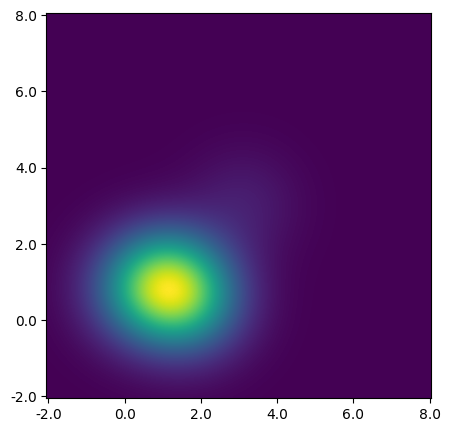

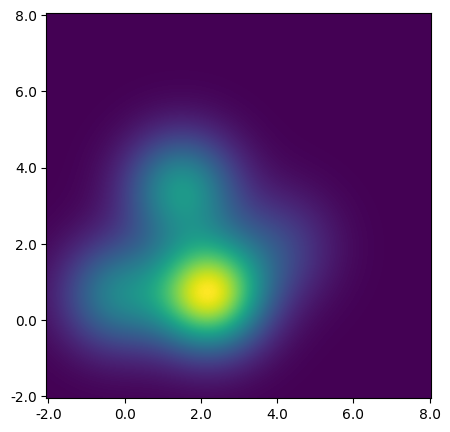

In [158]:
plt.style.use('default')
MoG_plot(pi_GD, mu_GD, cov_GD)
MoG_plot(pi_EM[0], mu_EM[0], cov_EM[0])